<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1">Imports</a></span></li><li><span><a href="#Define-parameters" data-toc-modified-id="Define-parameters-2">Define parameters</a></span></li><li><span><a href="#Perform-cross-validation" data-toc-modified-id="Perform-cross-validation-3">Perform cross-validation</a></span></li><li><span><a href="#Analyze-results" data-toc-modified-id="Analyze-results-4">Analyze results</a></span></li><li><span><a href="#Plot-confusion-matrix" data-toc-modified-id="Plot-confusion-matrix-5">Plot confusion matrix</a></span></li></ul></div>

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime
import os.path
import random
from imblearn.under_sampling import RandomUnderSampler
import sklearn.metrics 
from sklearn import tree, ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn import calibration
import utils.bookdroputils as bd
import sklearn.model_selection as model_selection

# Define parameters

In [2]:
# Specify the dataset to use
data_set = 'paperbacks' # 'boardgames' or 'paperbacks'

# Find directory for that dataset
mydir = os.path.join('data',data_set)

# Number of folds for cross-validation
folds = 10
# Number of timepoints to search ahead for a price drop
future = 60
# Fraction of the price considered a 'drop'
# E.g., 0.1 for a 10% price drop
drop_frac = .1

# Perform cross-validation

In [3]:
# Set random seeds for reproducability
random.seed(99)
np.random.seed(99)

# Collect list of files in the dataset
file_list = [
    f for f in os.listdir(mydir) if os.path.isfile(os.path.join(mydir, f))
]
# Count number of files
num_files = len(file_list)
# Initialize data structure for the validation metrics
results = list()

# Calculate number of products in the test set
ntest = int(np.floor((1 / folds) * num_files))
# Generate lists of file indices
full_idx_list = np.arange(0, num_files)
possible_test_idx = np.copy(full_idx_list)

# Generate train and test sets
train_list = list()
test_list = list()
for fold in range(folds):
    test_list.append(
        np.random.choice(possible_test_idx, size=ntest, replace=False))
    train_list.append(np.setdiff1d(full_idx_list, test_list[-1]))
    possible_test_idx = np.setdiff1d(possible_test_idx, test_list[-1])

# Perform cross-validation
for fold in range(folds):
    print('fold ' + str(fold + 1) + ' of ' + str(folds))

    # Select train and test sets
    test_idx = test_list[fold]
    train_idx = train_list[fold]

    # Initialize storage for features, labels, simulation data
    X = list([list([]), list([])])
    Y = list([list([]), list([])])
    dollars_spent = list([list([]), list([])])
    time_waited = list([list([]), list([])])

    # Keep track of which files we are processing (0=train, 1=test)
    count = -1

    for idx in [train_idx, test_idx]:
        count += 1
        # Select training or test files
        file_subset = np.array(file_list)[idx]
        # For each product
        for product_id in file_subset:
            # Read file
            df = pd.read_csv(os.path.join('data', data_set, product_id))
            # Drop missing values
            df.dropna(inplace=True)
            # Convert prices to array
            prices = np.array(df['price'])

            # Sample data at 1-month intervals, starting at a random point in time
            for k in range(
                    random.randint(0, 30) + 120 + 5,
                    df.shape[0] - future - 30, 60):

                # Extract price features
                features = bd.compute_features(prices[:k + 1], drop_frac)

                # Store the features
                X[count].append(features)

                # Store the class label
                if np.any(prices[(k + 1):(k + future + 1)] <
                          (1 - drop_frac) * prices[k]):
                    Y[count].append(1)
                else:
                    Y[count].append(0)

                # Extract the prices in the lookahead period
                future_prices = prices[(k + 1):(k + future + 1)]

                # Compute dollars spent and time waited for each strategy
                if Y[count][-1] == 1:
                    idx_below = np.argwhere(future_prices < (1 - drop_frac) *
                                            prices[k])[0].astype(int)[0]
                    bookdrop_price = future_prices[idx_below]
                    bookdrop_wait = idx_below + 1
                    tracker_price = future_prices[idx_below]
                    tracker_wait = idx_below + 1
                    perfect_price = future_prices[idx_below]
                    perfect_wait = idx_below + 1

                else:
                    bookdrop_price = prices[k + future]
                    bookdrop_wait = future
                    tracker_price = prices[k + future]
                    tracker_wait = future
                    perfect_price = prices[k]
                    perfect_wait = 0

                # Store the dollars spent
                dollars_spent[count].append(
                    np.array([
                        perfect_price, bookdrop_price, tracker_price,
                        prices[k], prices[k + future]
                    ]))

                # Store the time waited
                time_waited[count].append(
                    np.array([perfect_wait, bookdrop_wait, tracker_wait]))

    # Convert observations to arrays
    x_train = np.array(X[0])
    x_test = np.array(X[1])
    y_train = np.array(Y[0])
    y_test = np.array(Y[1])
    spending = np.array(dollars_spent[1])
    waiting = np.array(time_waited[1])

    # Hold out some training data to calibrate the classifier
    x_cal, x_train, y_cal, y_train = model_selection.train_test_split(
        x_train, y_train, train_size=0.2, test_size=0.8)

    # Balance classes in training set
    undersample = RandomUnderSampler(sampling_strategy='majority')
    x_train_balanced, y_train_balanced = undersample.fit_resample(
        x_train, y_train)

    # Define parameters for the random forest model
    parameters = {
        'bootstrap': True,
        'min_samples_leaf': 3,
        'n_estimators': 200,
        'min_samples_split': 10,
        'max_features': 'sqrt',
        'max_depth': 6,
        'max_leaf_nodes': None
    }
    # Initialize the model
    RF_model_uncalibrated = RandomForestClassifier(**parameters)
    # Fit the model
    RF_model_uncalibrated.fit(x_train_balanced, y_train_balanced)
    # Predict probabilities on the test set
    uncalibrated_probs = RF_model_uncalibrated.predict_proba(x_test)
    
    # Model calibration
    # Create calibrated model
    RF_model = calibration.CalibratedClassifierCV(RF_model_uncalibrated,
                                                  cv="prefit",
                                                  method='sigmoid')
    # Fit the model
    RF_model.fit(x_cal, y_cal)
    calibrated_probs = RF_model.predict_proba(x_test)
    # Find the classification threshold that gives the same
    # outputs as the calibrated classifier
    threshold = np.quantile(
        calibrated_probs[:, 1],
        np.sum(uncalibrated_probs[:, 1] <= .5) /
        np.size(uncalibrated_probs[:, 1]))
    # Make predictions
    y_pred = (calibrated_probs[:, 1] > threshold).astype(int)

    # Calculate accuracy on the test set
    RFscore = sklearn.metrics.accuracy_score(y_test, y_pred)

    # Compute spending for each strategy
    cost_perfect = np.sum(spending[:, 0])
    cost_bookdrop = np.sum(spending[y_pred == 0, 3]) + np.sum(
        spending[y_pred == 1, 1])
    cost_tracker = np.sum(spending[:, 2])
    cost_now = np.sum(spending[:, 3])
    cost_wait = np.sum(spending[:, 4])

    # Compute time waited for each strategy
    lag_perfect = np.sum(waiting[:, 0])
    lag_bookdrop = np.sum(waiting[y_pred == 1, 1])
    lag_tracker = np.sum(waiting[:, 2])

    # Compute errors for the confusion matrix
    TN = np.sum(np.bitwise_and(y_test == 0, y_pred == 0))
    FP = np.sum(np.bitwise_and(y_test == 0, y_pred == 1))
    FN = np.sum(np.bitwise_and(y_test == 1, y_pred == 0))
    TP = np.sum(np.bitwise_and(y_test == 1, y_pred == 1))

    results.append([
        cost_perfect, cost_bookdrop, cost_tracker, cost_now, cost_wait,
        RFscore, lag_perfect, lag_bookdrop, lag_tracker, TN, FP, FN,
        TP
    ])

fold 1 of 10
fold 2 of 10
fold 3 of 10
fold 4 of 10
fold 5 of 10
fold 6 of 10
fold 7 of 10
fold 8 of 10
fold 9 of 10
fold 10 of 10


# Analyze results

In [6]:
# Convert results to dataframe
df = pd.DataFrame(results,
                  columns=[
                      'cost_perfect', 'cost_BookDrop', 'cost_tracker',
                      'cost_now', 'cost_wait', 'accuracy', 'lag_perfect',
                      'lag_BookDrop', 'lag_tracker', 'TN', 'FP', 'FN', 'TP'
                  ])

# Accuracy
print('Accuracy: ' + str(df['accuracy'].mean()))

# Precision
print('Precision: ' + str((df['TP'] / (df['TP'] + df['FP'])).mean()))

# Recall
print('Recall: ' + str((df['TP'] / (df['TP'] + df['FN'])).mean()))

# Results of simulated purchases
# Savings
df['perfect_savings'] = 100 * (1 - (df['cost_perfect'] / df['cost_now']))
df['BookDrop_savings'] = 100 * (1 - (df['cost_BookDrop'] / df['cost_now']))
df['tracker_savings'] = 100 * (1 - (df['cost_tracker'] / df['cost_now']))
df['wait_savings'] = 100 * (1 - (df['cost_wait'] / df['cost_now']))
# Efficiency
df['BookDrop_efficiency'] = df['BookDrop_savings'] / df['perfect_savings']
df['tracker_efficiency'] = df['tracker_savings'] / df['perfect_savings']
df['wait_efficiency'] = df['wait_savings'] / df['perfect_savings']
# Days waited
# (first, count number of observations)
# (also, lag is expressed in # of 12-hr periods)
df['num_obs'] = df['TN'] + df['TP'] + df['FN'] + df['FP']
df['perfect_days'] = (df['lag_perfect'] / 2) / df['num_obs']
df['BookDrop_days'] = (df['lag_BookDrop'] / 2) / df['num_obs']
df['tracker_days'] = (df['lag_tracker'] / 2) / df['num_obs']
df['wait_days'] = future / 2
# Time saved
df['perfect_time_savings'] = 100 - 100 * (df['perfect_days'] / df['wait_days'])
df['BookDrop_time_savings'] = 100 - 100 * (df['BookDrop_days'] / df['wait_days'])

# Compute means
means = df.mean()

# Create a table of metrics for simulated purchases
simulation_results = pd.DataFrame(
    [[means['perfect_savings'], 1, means['perfect_days'],means['perfect_time_savings']],
     [means['BookDrop_savings'], means['BookDrop_efficiency'], means['BookDrop_days'],means['BookDrop_time_savings']],
     [means['tracker_savings'],means['tracker_efficiency'],means['tracker_days'],''],
     [means['wait_savings'],means['wait_efficiency'],means['wait_days'],'']
    ],
    columns=['savings', 'efficiency', 'wait_time', 'time_saved'],
    index=['Perfect','BookDrop','Tracker only','Wait'])
simulation_results

Accuracy: 0.7289125084143847
Precision: 0.37141113258020403
Recall: 0.6268935301538869


,savings,efficiency,wait_time,time_saved
Perfect,4.665959,1.000000,2.495360,91.6821
BookDrop,2.560787,0.538179,7.503988,74.9867
Tracker only,1.747138,0.416086,26.834552,
Wait,-0.032769,-0.007274,30.000000,


# Plot confusion matrix

<Figure size 648x648 with 0 Axes>

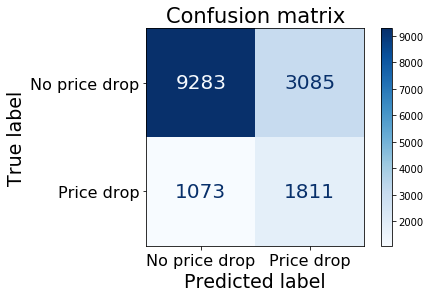

In [11]:
# Compute each cell's value
TN = df['TN'].sum()
FP = df['FP'].sum()
FN = df['FN'].sum()
TP = df['TP'].sum()

# Generate the figure
fig = plt.figure(figsize=(9,9))
CM = sklearn.metrics.ConfusionMatrixDisplay(
    np.array([[TN, FP], [FN, TP]]),
    display_labels=['No price drop', 'Price drop']).plot(cmap=plt.cm.Blues,
                                                         values_format='d')
ax1 = CM.ax_
tx = CM.text_

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.set_title("Confusion matrix", fontsize=21)

ax1.set_ylabel(ylabel="True label", fontsize=19)
ax1.set_xlabel(xlabel="Predicted label", fontsize=19)

for i in [0, 1]:
    for j in [0, 1]:
        tx[i][j].set_fontsize(20)